# Retina-net (Focal Loss for Dense Object Detection)

## 1. Introduction
- state-of-art object detector은 two-stage를 기반으로 하는데 <br>
one-stage로 two-stage만큼의 정확성을 높일수 있을까?하는 질문에서 시작된다.<br>
- 또한 Object detection 모델은 이미지 내의 객체의 영역을 추정하고 IoU threshold에 따라 <br>
positive(object)와 negative(background) sample로 구분한 후, 이를 활용하여 학습한다.
- 하지만 일반적으로 이미지 내 object의 수가 적기 때문에 <br> **positive sample(object, foreground)**은 negative sample(background)에 비해 **매우 적다.** <br>
그래서 둘사이 큰차이가 생겨서 **class imbalance**가 발생한다.

### class imbalance
- R-CNN처럼 two-stage cascade, sampling heuristic으로 해결된다.
- region proposal 단계(예:Selective search, Edgeboxes, Deepmask, RPN)에서 <br>
object 후보군들의 수를 줄였으나 대부분의 background를 필터링한다(잔존시킨다).
- 다음 단계인 classification에서는 foreground과 background 비율을 1:3로 설정(hard negative mining)하거나 online hard example mining(OHEM)처럼 sampling heuristic은 foreground와 background사이 균형을 유지하기위해 진행된다.
- 대조적으로 one-stage detector는 이미지 전체에서 sampling되는 많은 object 후보군들을 처리해야한다.
- 비슷한 sampling heuristic이 적용될 수도 있지만 여전히 쉽게 분류되는 background에 의해 training 절차가 지배되기 때문에 비효율적이다. 
- 이러한 비효율성은 일반적으로 bootstrapping과 hard example mining 같은 기술을 통해 해결되는 object detection의 고전적인 문제이다.
> 이 논문에서는 class imbalance를 다루는 이전의 접근방식보다 더 효과적인 **새로운 loss function**을 제안한다.<br>
> loss function는 동적으로 스케일링된 cross entropy loss이며, 올바른  class(object)에 대한 신뢰도가 증가함에 따라 스케일링 계수가 0으로 감소한다. <br>
> 직관적으로 스케일링 계수는 trainig하는동안 easy(쉽게 background라고 예측할수있는) example의 기여도를 down-weight(가중치를 낮춰주고)하고 hard(object가 있다고 예측할수있는) example에 중점을 둔다.

- **Focal loss**
> 높은 정확성, hard example mining과 sampling heuristic의 대안을 능가하는 one-stage detector<br>
- **RetinaNet**
>피처맵 피라미드와 앵커박스 사용을 특징으로, ResNet-101-FPN backbone을 기반으로 효율과 정확성이 높은 모델이다.



## 2. Focal Loss
- 정의 : training동안 foreground와 background사이 매우 높은 imbalance를 해결하기위한 one-stage object dection (ex: 1:1000)

### 2-1. cross entropy (CE)
- focal loss는 binary classification인 cross entropy에서 출발한다.<br>
> $y=1$ : 앵커박스에 object가 있을때 확률 => $p$ <br>
> $ CP(p,y) = 
  \begin{cases}
    -log(p),         \;if\; y=1 \\
    -log(1-p),       otherwise.
  \end{cases}$ <br>
> $y \in \{-1, 1\} $ : groundtruth 값 <br>
> $p \in [0, 1]$ : 앵커박스안에 object가 class 객체인지 아닌지 확률

- $y=1$일때 $p_t$를 다음과 같이 정의할 수 있다.
> $ p_t = 
  \begin{cases}
    p,      \;if\; y=1\\
    1-p,    otherwise.
  \end{cases}$
>> 그래서 $CE(p,y)=CE(p_t)=-log(p_t)$이다.

 - CE loss는 아래 Figure 1의 그래프에서 파란색 곡선이다.<br>
<img src='https://drive.google.com/uc?export=download&id=1Jb_1kbCogyN8-EjGFftmZd_g4lAk6scc' height="500" width="500"><br>
 - 이 loss의 주목할만한 특징은 plot에서 보여지는데 쉽게 분류되는 ($p_t(IoU)$ >=0.5일때) <br>
easy example(물체가 있는지, 없는지 확신할수있는 확률이 높은 example)들도 <br> 사소하지 않은(무시할 수 없는) 규모의 loss를 초래한다.<br>
> easy example들의 많은 수의 loss들를 합하면, <br>
우리가 실제로 판별해야할 rare class(object인지 아닌지 애매한 class)들을 압도하는 loss가 될 수 있어서 <br>
training하고싶은 loss들을 training할 수 없고 학습 효율이 떨어진다.

### 2-2. Balanced Cross Entropy
- class imbalance를 해결하기 위한 일반적인 방법은 **weighting factor($\alpha$)를 넣는 것**이다.
> $\alpha \in [0, 1]$ : class 1(=foreground, object가 있을때, $y=1$) 일때 <br>
> $1- \alpha $ : class-1(=background, object가 없을때, $y=o.w$) 일때 

- 실제로 α는 inverse class 빈도에 의해 설정되거나 cross-validation에 의해 설정되는 hyperparameter로 처리될 수 있다.
- 표기상의 편의를 위해 $p_t$를 정의한 방법과 유사하게 $α_t$를 정의한다. α-balanced CE loss를 다음과 같이 쓴다.
> $CE(p_t) = -\alpha_t log(p_t)$



### 2-3. Focal Loss Definition

---

* hard example과 easy example구분법: loss값이 0.6이상이면 hard 이하면 easy


- 실험에서 알 수 있는것처럼, 큰 imbalance는 많은(dense) detectoer를 training하는 동안에 <br>
cross-entropy의 loss를 압도해서 쉽게 분류되는 negative(background)가 대부분의 loss와 gradient를 차지한다.
- $\alpha$가 positive/negative인지(object가 있는지 없는지) balance하는동안 <br>
easy/hard(foreground인지, background인지) example을 구분하지 않는다.
- 대신에 우리는 easy example(쉽게 background임을 구분하는)에 down-weight하고 hard negative에 집중하는 loss function을 재구성한다.
> down-weight : 가중치를 낮춰서 학습의 비중을 낮춘다는 의미
- 공식적으로 **modulating factor인 $(1-p_t)^{\gamma}$와 tunable focusing parameter $\gamma\geq0$**를 cross entropy에 추가한다.
> $FL(p_t)=-(1-p_t)^{\gamma}log(p_t)$

- focal loss는 $\gamma \in [0,5]$ 값인 ${0, 0.5, 1, 2, 5}$을 대입하여 Figure 1를 보여준다.
- focal loss는 두가지 특성이 있다.
> 1. $p_t$와 modulating factor의 관계 <br>
> - example을 잘못 분류해서 $p_t$가 매우 작을때(hard example일때), <br> 
>> modulating factor는 1에 가까워지고 loss값은 영향을 받지 않는다.
> - $p_t \rightarrow1$이면 <br>
>> modulating factor는 0에 수렴하고 잘 분류된(쉽게 background라고 확신할 확률이 높은) example들의 loss를 down-weight한다.
>2. Focusing factor $ \gamma $는 easy example을 down-weighted하는 정도를 부드럽게 조절한다. <br>
> - $ \gamma =0 $이면, Focal loss는 CE와 같고, <br>
> - $ \gamma$가 증가하면, modulating factor인 $(1-p_t)^{\gamma}$도 증가한다.
>> $ \gamma =2 $가 가장 잘 작동한다.

- 직관적으로 modulating factor은 easy example의 loss 기여도를 줄이고, example이 작은 loss를 받는 범위를 늘리는 역할을 한다. 
> -  $ \gamma =2 $와 example에 물체가 있다고 확신하는 확률, 물체가 있을 확률 $p_t=0.9$일때, 
>> CE에 비해 100배 적은 loss를 가지고, <br>
> - $p_t ≈ 0.968$ 일때, 
>> 1000배의 적은 loss를 가진다.<br>
- 이는 잘못 분류된 (object가 있는데 background로 예측하거나 background를 object로 예측하는) <br>
examples을 수정하는 중요도를 상승시킨다는 의미이다.
> $ \gamma =2, 0.5 \geq p_t $일때 loss가 최대 4배로 줄어든다.
- 이렇게 **$p_t$에 따라 loss값을 조절하여 easy example의 영향을 낮추고 hard example의 영향을 높이는 것**이다.

### 2-4. $\alpha$-balanced variant of the focal loss
> $FL(p_t)=-\alpha(1-p_t)^{\gamma}log(p_t)$

- the non-α-balanced 형태에 비해 **약간 향상된 정확도를 제공해서** 이 공식을 채택한다. 
- 마지막으로, loss layer의 구현은 $p$를 계산하기 위한 시그모이드 연산과 loss 계산을 결합하여 <br>
더 큰 수치적 안정성을 가져온다는 점에 주목한다.


### 2-5. Class Imbalance and Model Initialization

- binary classification 모델은 기본적으로 $y = -1$ 또는 $1$을 출력할 동일한 확률을 갖도록 초기화된다. 
- 이러한 초기화에서 class imbalance이 있는 경우 빈도가 높은 class가 전체 loss을 차지하고, 초기 training에서 불안정성을 유발할 수 있다. 
- 이를 해결하기 위해 학습 시작 시 rare class(object인지 아닌지 애매한 class)에 대한 모델에서 추정한 $p$ 값에 대한 prior 개념을 도입한다. 
> prior을 π로 정의하고, 모델의 추정된 $p$가 클래스가 낮도록 설정한다. (예로 0.01)
- 이것은 loss function의 변경이 아니라 Model Initialization의 변경이다. <br>
- 이것이 heavy class imbalance의 경우 cross entropy와 focal loss 둘다 training 안정성을 향상시킨다.

### 2-6. Class Imbalance and Two-stage Detectors
-  Two-stage detectors는 종종 α-balancing이나 focal loss 없이 사용하지 않고 cross entropy loss로 training된다. <br>
대신 1) a two-stage cascade와 2) 편향된 minibatch sampling을 통해 class Imbalance을 해결한다. 
- 1) a two-stage cascade
> 무한한 세트→ 1,000 또는 2,000으로 줄이는 object proposal mechanism <br>
>> 중요한 점 : 선택된 the selected proposal는 random이 아니지만, <br>
대부분의 easy negative(쉽게 background라고 예측하는 example)를 제거하는 true object locations에 해당할 가능성이 높다는 것이다.
- 2) 편향된 minibatch sampling 
> 일반적으로 예를 들어 positive와 negative의 비율이 1:3인 minibatches를 구성하는데 사용된다. <br>
> 이 비율은 암시적 sampling을 통해 구현되는 α- balancing factor이다. <br>
> 제안된 focal loss는 loss function를 통해 직접 one-stage detection system에서 이러한 mechanism을 해결하도록 설계되었다.

## 3. RetinaNet Detector

<img src='https://drive.google.com/uc?export=download&id=1WhkpJ13lEeHrfWY-txv54KRq8x_HH7XV' height="400" width="1000"> <br>

이제 focal loss를 적용할 RetinaNet의 전체적인 구조를 살펴볼수 있다. <br>
Backbone은 Resnet을 사용하고, FPN(Feature Pyramid Networks)을 적용하였다. <br>
그리고 detect를하는 head 부분에서는 RPN head대신 자체적인 컨볼루션 head를 사용하였다. <br>

### 3-1. Backbone Part

<img src='https://drive.google.com/uc?export=download&id=1wK1RstkfX1geuWM2WjTHvgO2aK4zLqoE' height="750" width="1000"> <br>


Backbone 부분을 살펴보면 FPN과 상당히 유사함으로 [FPN논문](https://arxiv.org/pdf/1612.03144.pdf)을 참조하면 된다.<br> 
1. 인풋 이미지(그림은 640x640으로 설정)부터 차례대로 C3,C4,C5의 피쳐맵을 뽑아낸다. <br>
(컴퓨팅 리소스를 많이 차지한다고 판단해 FPN과 달리, C2는 사용하지않는다)<br>
2. 1x1 컨볼루션 연산을 통해 채널을 256으로 맞춰준다.
3. 이후 C5부터 Top-Down pathway와 lateral connection을 이용해 다양한 스케일을 커버할 수 있는 효율적인 네트워크를 구성한다. <br>
(그 전 피쳐맵과 연결하여 semantic value를 높여서) <br>
4. 또다른 FPN과의 차이점인 P6는 C5를 기반으로 3x3 컨볼루션 다운샘플링하여 생성한다.
5. 이렇게 모두 P3 ~ P7 까지의 피쳐맵을 획득한다.

> 우측 하단에는 생성될 앵커박스의 스케일과 비율도 만들어놓았다. <br>
FPN과 다르게 각 피쳐맵마다 3개의 스케일과 3개의 비율, 각 9개의 앵커가 사용된다. <br>
가장 작은 앵커는 $32$x$2^0=32$ 이고, 가장 큰 앵커는 $512$x$2^\frac{2}{3}$ 약 $813$이다.


### 3-2. Head Part

<img src='https://drive.google.com/uc?export=download&id=1Wj-5cuDS1xu1UUGxN8j6a3FZUvoSOnAQ' height="550" width="800"> <br>

이제 생성된 P3 ~ P7의 피쳐맵에 각각 Head를 붙여줘서 detecting을 할 차례이다. <br> 
RetinaNET은 one-stage 네트워크이므로 RoI Pooling을 사용하지않고 위와같이 가중치 공유 기반의 컨볼루션 detect(predict) head를 사용한다. <br>
이것은 각각 Classification을 하는 Class subnet과 Box regression을 하는 Box subnet으로 나뉜다. <br>
즉 256채널을 각각 KA, 4(cx,cy,w,h)A로 매핑한다. <br>
A는 앵커의 수(9개)이고, K는 detect할 클래스의 수이다. 여기서는 Background를 포함하지않으며 파스칼 VOC 기준으로 20이다. <br>


### 3-3. Anchors

<img src='https://drive.google.com/uc?export=download&id=1WD13pmz-X9QjjUiIzVKO_ph8PjPHQ4pl' height="450" width="700"> <br>


RetinaNet에서는 매우 많은 앵커박스를 사용하는데 이것을 만드는 기준은 위와 같다. <br>
FPN에서는 각 피쳐맵 스케일마다 하나의 크기와 3개의 비율을 가지는 앵커박스를 사용했고, <Br> RetinaNet에서는 각 피쳐맵 마다 3개의 크기, 3개의 비율을 가지는 앵커박스 총 9개를 사용한다. <br>
예를들어 [600,600,3]의 input 이미지가 들어왔다면 P3의 크기는 $\frac{1}{8}$이 된 75x75 사이즈의 피쳐맵이 될것이다. <br>
이제 각 그리드 셀 마다 9개의 앵커가 class개의 vector, <br>
4개(박스좌표)의 vector가 각각 tiled되어 class subnet , box subnet의 정보를 구성하는 박스가 된다. <br>
학습시에는 IoU가 0.5 이상인 박스들만이 positive, <br>
0.4 이하인 박스들은 negative(background)로 할당이 된다. <br>

<img src='https://drive.google.com/uc?export=download&id=1EHU8rvbRUEpUegaW90fXEGIDFJInUEVP' height="530" width="1000"> <br>


그렇다면 [Bx600x600x3]의 input 이미지가 들어온다면 앵커박스는 총 몇개가 될까? <br>
첫번째 피쳐맵인 P3에서는 $\frac{1}{8}$로 줄어든 75x75x9(앵커) = 50625개 <br>
여기서 이미 5만개가 넘는 앵커박스를 생성하게 된다. <br>
그렇게 마지막 P7까지 더해주면 output은 [B, 67995, 80]이 될 것이다. (80=class 80개인 coco dataset)<br>
> SSD나 FPN과 달리 매우 dense한(많은) 앵커를 사용하여 정확한 객체 탐지를 노리는데, <br> 이것은 background 가중치를 줄이는 focal loss를 사용하기 때문에 가능하다.

## 4. Training & Inference

### 4-1. Inference 

* 속도향상을 위해 confidence를 0.5이상으로 threshold를 하고 제일 높은 score들만 이용 해서 box prediction을 decode하였다.
 -> 여기서 decode란 relative offset을 ground-truth 좌표로 바꾸는 과정을 말한다. 
 
* focal loss의 경우 classificataion subnet자체에 적용을 시켰다. 

* retinanet을 학습할때 focal loss는 한 이미지당 전체 앵커에 대해서 적용을 했고 따라서 전체 focal loss는 전체 앵커의 focal loss합으로 계산이 되고 ground truth box로 할당된 앵커의 개수를 normalizationn했다.

 
* 모든 수준의 top prediction이 병합되고 0.5 threshold로 NMS(non-maximum-suppression)를 수행하여  detection 결과를 얻는다.

### 4-2. initialization
* initialization을 쓰는이유는  많은 수의 background anchor가 훈련의 첫 번째 반복에서 불안정한 큰 손실 값을 생성하는 것을 방지하기 위함이다.

 -> 첫 번째 반복에서 불안정한 큰 손실 값을 생성되는 이유는 class imbalance때문이다.

* RetinaNet 서브넷의 final conv layer를 제외한 모든 새로운 convlayer는  b(bias) = 0으로 초기화되고 가우스 가중치는 σ = 0.01로 초기화 된다.

* classification subnet의 final conv latyer에 대해 bias 초기화를 b = − log((1 − π)/π)로 설정한다. 여기서 π는 훈련 시작 시 모든 앵커가 ~π의 confidence를 가진 foreground로  레이블되어야 한다. 

* 논문 실험에서는 π = 0.01을 사용한다. 

### 4-3. optimization
* stochasti gradient descent(SGD)를 사용한다.

* 달리 지정하지 않는 한 모든 모델은 초기 학습률이 0.01이고 90,000번의 반복학습을 한다. 

* 달리 명시되지 않는 한 data augmentation 의 유일한 형태로 수평 이미지 뒤집기(좌우반전) 를 한다.

* 훈련 손실: box regression에 사용된 focal loss와  standard smooth L1 loss의 합입니다.

### 4-4. Training
* resnet 50또는 resnet101을 사용했다.

* training과 test 모두 이미지크기를 600픽셀로 잡았다.

* RetinaNet의 판단 속도 향상을 위해, 각 FPN level에서 가장 box prediction 점수가 높은 1,000개의 box만 result에 사용하였다.

* RetinaNet을 COCO 데이터셋을 통해 학습시킨 후 서로 다른 loss function을 사용하여 AP 값을 측정했다.






### 4-5. Training 결과

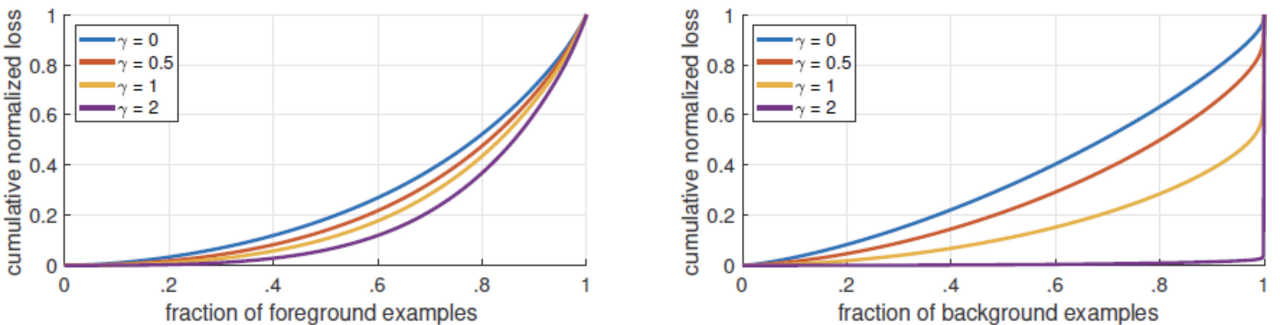

* foregound example일 경우 감마에 따른 변화가 크지않고 background example일 경우 감마에 따른 변화가크다


* easy negative에 집중을 줄이고 hard negative에 집중한다.

### 4-6. Two stage와 One stage의 AP비교

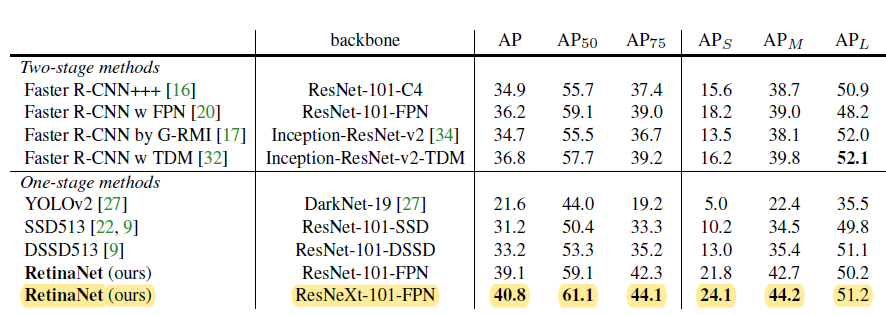

* RetinaNet의 성능은 기존 two-stage, one-stage 모델들과 비교해보았을 때도, 우수함을 알 수 있있다.

### 4-7. CE와 focal loss비교

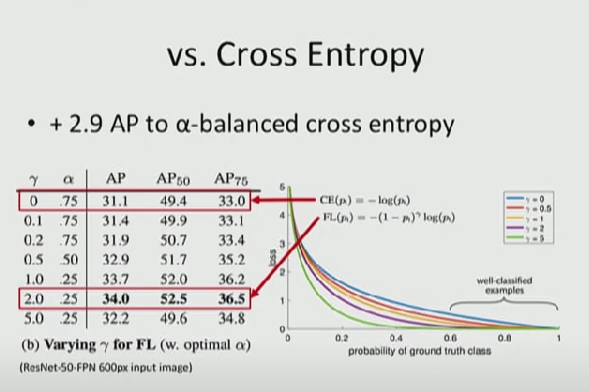

* Best OHEM 보다 Best Focal Loss가  AP값이 더 높다.

### 4-8. Accuracy 와 speed는 trade-off관계이다.

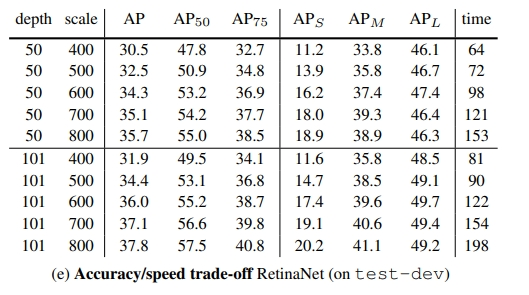

---
Image & Reference

[paper](https://arxiv.org/pdf/1708.02002.pdf) [1](https://csm-kr.tistory.com/5)